In [ ]:
# default_exp classification.data.transforms

In [ ]:
# hide
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [ ]:
# hide
import warnings

from nbdev.export import *
from nbdev.showdoc import *

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Data augmentation in computer vision
> Transforms to apply data augmentation in Computer Vision for Image Classification Tasks

In [ ]:
# export
from typing import *

import albumentations as A
import numpy as np
import torchvision.transforms as T
from timm.data.auto_augment import auto_augment_transform, rand_augment_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data.transforms import RandomResizedCropAndInterpolation, _pil_interp
from torch import Tensor

<IPython.core.display.Javascript object>

In [ ]:
# export
imagenet_stats = (IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
cifar_stats = ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
mnist_stats = ([0.15, 0.15, 0.15], [0.15, 0.15, 0.15])

_all_ = ["imagenet_stats", "cifar_stats", "mnist_stats"]

<IPython.core.display.Javascript object>

In [ ]:
# for tests
from fastcore.all import Path
from nbdev.export import Config
from torch.utils.data import DataLoader

from gale.classification.data.common import (
    ClassificationDataset,
    ClassificationMapper,
    FolderParser,
    show_image_batch,
)
from gale.collections.download import download_and_extract_archive

URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_path = Path(Config().path("nbs_path")) / "data"

# download a toy dataset
download_and_extract_archive(url=URL, download_root=data_path, extract_root=data_path)

# take a peek at the structure of the dataset
path = data_path / "hymenoptera_data"

parser = FolderParser(path / "train")

Using downloaded and verified file: /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip
Extracting /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip to /Users/ayushman/Desktop/gale/nbs/data


<IPython.core.display.Javascript object>

In [ ]:
# export
def imagenet_no_augment_transform(
    size: Union[Sequence, int] = 224, interpolation: str = "bilinear"
) -> T.Compose:
    """
    The default image transform without data augmentation.

    It is often useful for testing models on Imagenet.
    It sequentially resizes the image and takes a central cropping.
    """
    interpolation = _pil_interp(interpolation)
    tfl = [T.Resize(size, _pil_interp(interpolation)), T.CenterCrop(size)]
    return T.Compose(tfl)

<IPython.core.display.Javascript object>

**Args:**

- `size`: Desired output size. If size is a sequence like (h, w), output size will be matched to this. If size is an int, smaller edge of the image will be matched to this number. i.e, if height > width, then image will be rescaled to (size * height / width, size).
- `interpolation`: Desired interpolation

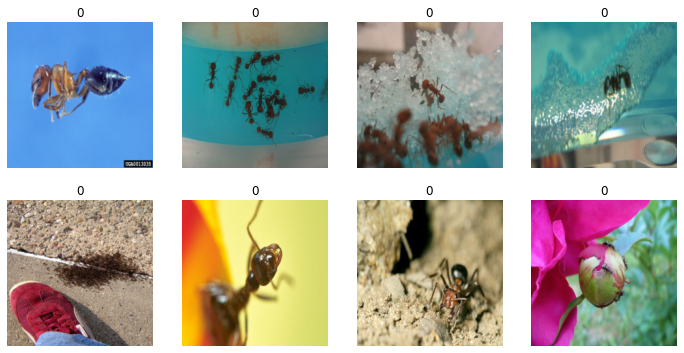

<IPython.core.display.Javascript object>

In [ ]:
transforms = imagenet_no_augment_transform(size=(224, 224), interpolation="bicubic")
mapper = ClassificationMapper(transforms)
dset = ClassificationDataset(mapper, parser)
dls = DataLoader(dset, batch_size=8, shuffle=False)
samples = next(iter(dls))
show_image_batch(samples)

In [ ]:
# export
def imagenet_augment_transform(
    size: int = 224,
    scale: Optional[float] = None,
    ratio: Optional[float] = None,
    interpolation: str = "random",
    hflip: Union[float, bool] = 0.5,
    vflip: Union[float, bool] = False,
    color_jitter: Union[Sequence, float] = 0.4,
    auto_augment: Optional[str] = None,
    mean: Optional[Sequence[float]] = IMAGENET_DEFAULT_MEAN,
) -> T.Compose:
    """
    The default image transform with data augmentation.It is often useful for training models on Imagenet.

    Adapted from: https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/transforms_factory.py
    """

    scale = tuple(scale or (0.08, 1.0))  # default imagenet scale range
    ratio = tuple(ratio or (3.0 / 4.0, 4.0 / 3.0))  # default imagenet ratio range

    transforms = [
        RandomResizedCropAndInterpolation(size, scale, ratio, interpolation),
    ]

    if hflip and hflip > 0:
        transforms.append(T.RandomHorizontalFlip(p=hflip))
    if vflip and vflip > 0.0:
        transforms.append(T.RandomVerticalFlip(p=vflip))

    if auto_augment:
        assert isinstance(auto_augment, str)
        if isinstance(size, (tuple, list)):
            size_min = min(size)
        else:
            size_min = size

        aa_params = dict(
            translate_const=int(size_min * 0.45),
            img_mean=tuple([min(255, round(255 * x)) for x in mean]),
        )

        if interpolation and interpolation != "random":
            aa_params["interpolation"] = _pil_interp(interpolation)
        if auto_augment.startswith("rand"):
            transforms += [rand_augment_transform(auto_augment, aa_params)]
        else:
            transforms += [auto_augment_transform(auto_augment, aa_params)]

    elif color_jitter is not None:
        # color jitter is enabled when not using AA
        if isinstance(color_jitter, (list, tuple)):
            # color jitter should be a 3-tuple/list if spec brightness/contrast/saturation
            # or 4 if also augmenting hue
            assert len(color_jitter) in (3, 4)
        else:
            # if it's a scalar, duplicate for brightness, contrast, and saturation, no hue
            color_jitter = (float(color_jitter),) * 3
        transforms += [T.ColorJitter(*color_jitter)]
    return T.Compose(transforms)

<IPython.core.display.Javascript object>

**Args:**

- `size`: Desired output size. If size is a sequence like (h, w), output size will be matched to this. If size is an int, smaller edge of the image will be matched to this number. i.e, if height > width, then image will be rescaled to (size * height / width, size).
- `scale`: Range of size of the origin size cropped.
- `ratio`: Range of aspect ratio of the origin aspect ratio cropped.
- `interpolation`: Desired interpolation.
- `hflip`: Probability for random horizontal flip. Active if `not False and > 0`.
- `vflip`: Probability for random vertical flip. Active if `not False and > 0`.
- `color_jitter`: Values of brightness, contrast, saturation and hue for `torchvision.transforms.ColorJitter`.
- `auto_augment`: String defining configuration of auto augmentation policies. Currently supports only [AutoAugment](https://arxiv.org/abs/1805.09501) and [RandAugment](https://arxiv.org/abs/1909.13719).
- `mean`: Image mean, required only if `auto_augment` is not None.

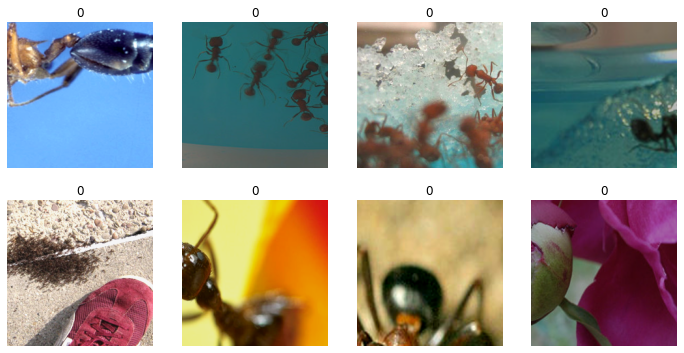

<IPython.core.display.Javascript object>

In [ ]:
transforms = imagenet_augment_transform(
    size=(224, 224),
    hflip=0.5,
    vflip=0.5,
    color_jitter=0.4,
)
mapper = ClassificationMapper(transforms)
dset = ClassificationDataset(mapper, parser)
dls = DataLoader(dset, batch_size=8, shuffle=False)
samples = next(iter(dls))
show_image_batch(samples)

**Applying `AutoAugment`**: 

To use `AutoAugment` we need to create a config str and specify the parameters. Under the hood the above functions uses [auto_augment_transform](https://github.com/rwightman/pytorch-image-models/blob/9a1bd358c7e998799eed88b29842e3c9e5483e34/timm/data/auto_augment.py#L511) from timm. Config str must be like should consists of multiple sections separated by dashes ('-'). The first section defines the AutoAugment policy `(one of 'v0', 'v0r', 'original', 'originalr')`. The remaining sections, not order sepecific determine
`mstd`(float std deviation of magnitude noise applied)

Ex - `original-mstd0.5` results in `AutoAugment` with `original policy, magnitude_std 0.5`

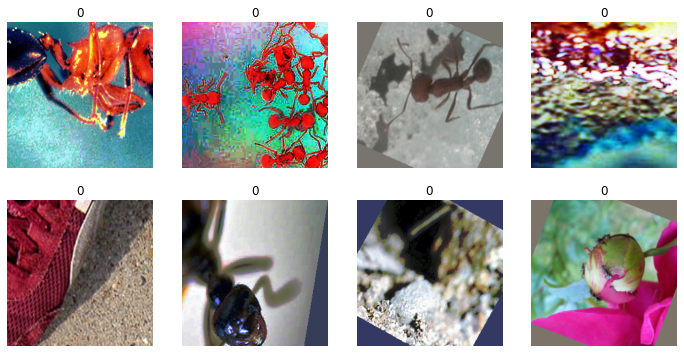

<IPython.core.display.Javascript object>

In [ ]:
transforms = imagenet_augment_transform(
    size=(224, 224), hflip=0.5, vflip=0.5, auto_augment="original-mstd0.5"
)
mapper = ClassificationMapper(transforms)
dset = ClassificationDataset(mapper, parser)
dls = DataLoader(dset, batch_size=8, shuffle=False)
samples = next(iter(dls))
show_image_batch(samples)

**Applying `RandAugment`**: 

To use `RandAugment` we need to create a config str and specify the parameters. Under the hood the above functions uses [rand_augment_transform](https://github.com/rwightman/pytorch-image-models/blob/9a1bd358c7e998799eed88b29842e3c9e5483e34/timm/data/auto_augment.py#L635) from timm. Config str must be like should consists of multiple sections separated by dashes ('-'). The first section defines the specific variant of `rand augment` `(currently only 'rand')`. 

The remaining sections, not order sepecific determine:
* `m` - integer magnitude of rand augment
* `n` - integer num layers (number of transform ops selected per image)
* `w` - integer probabiliy weight index (index of a set of weights to influence choice of op)
* `mstd` -  float std deviation of magnitude noise applied
* `inc` - integer (bool), use augmentations that increase in severity with magnitude (default: 0)

Ex - `rand-m9-n3-mstd0.5` results in `RandAugment` with `magnitude 9, num_layers 3, magnitude_std 0.5` & `rand-mstd1-w0` results in `magnitude_std 1.0, weights 0, default magnitude of 10 and num_layers 2`

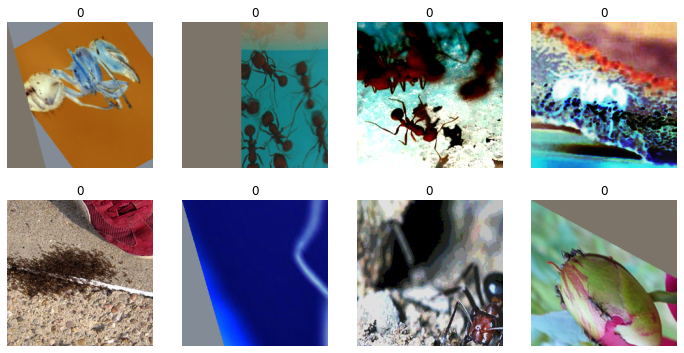

<IPython.core.display.Javascript object>

In [ ]:
transforms = imagenet_augment_transform(
    size=(224, 224), hflip=0.5, vflip=0.5, auto_augment="rand-m9-n3-mstd0.5"
)

mapper = ClassificationMapper(transforms)
dset = ClassificationDataset(mapper, parser)
dls = DataLoader(dset, batch_size=8, shuffle=False)
samples = next(iter(dls))
show_image_batch(samples)

In [ ]:
# export
def aug_transforms(
    presize: int = 260,
    size: int = 224,
    interpolation: int = 1,
    hflip: Union[float, bool] = 0.5,
    vflip: Union[float, bool] = False,
    max_lighting: Union[float, bool] = 0.2,
    p_lighting: float = 0.75,
    max_rotate: Union[float, int, bool] = 10.0,
    p_rotate: float = 0.5,
    max_warp: Union[float, bool] = 0.2,
    p_affine: float = 0.75,
    pad_mode: str = "reflect",
    mult: float = 1.0,
    xtra_tfms: Optional[List] = None,
) -> A.Compose:
    """
    Utility func to easily create a list of flip, rotate, zoom, lighting transforms.
    Inspired from : https://docs.fast.ai/vision.augment.html#aug_transforms
    """
    max_rotate, max_lighting, max_warp = (
        np.array([max_rotate, max_lighting, max_warp]) * mult
    )
    transforms = [
        A.Resize(presize, presize, interpolation=interpolation, always_apply=True)
    ]
    if hflip:
        transforms += [A.HorizontalFlip(p=hflip)]
    if vflip:
        transforms += [A.VerticalFlip(p=vflip)]
    if max_rotate:
        transforms += [
            A.Rotate(limit=max_rotate, interpolation=interpolation, p=p_rotate)
        ]
    if max_warp:
        transforms += [A.IAAAffine(scale=max_warp, p=p_affine, mode=pad_mode)]
    if max_lighting:
        transforms += [A.RandomBrightness(max_lighting, p=p_lighting)]
        transforms += [A.RandomContrast(max_lighting, p=p_lighting)]
    if xtra_tfms is not None:
        transforms += [xtra_tfms]

    transforms += [
        A.RandomResizedCrop(size, size, interpolation=interpolation, always_apply=True)
    ]
    return A.Compose(transforms)

<IPython.core.display.Javascript object>

This function utilizes transformations from `albumentations` library. First the Image is resized to `presize` , transformations are applied after which we `RandomCrop` to `size`.
`HorizontalFlip` (or `VerticalFlip` if `vflip`=True) with p=`hlip` (or `vflip`) is added when `hflip`=True. With `p_rotate` we apply a `albumentations.Rotate` of `max_rotate` degrees and if `max_warp` a `albumentations.IAAAffine` with scale=`max_warp` and model=`pad_mode`. With `p_lighting` we apply a change in brightness and contrast of `max_lighting`. Custonm `xtra_tfms` can be added, these must be a `List` contraining transformations from albumentations. `max_rotate`,`max_lighting`,`max_warp` are multiplied by `mult` so you can more easily increase or decrease augmentation with a single parameter.

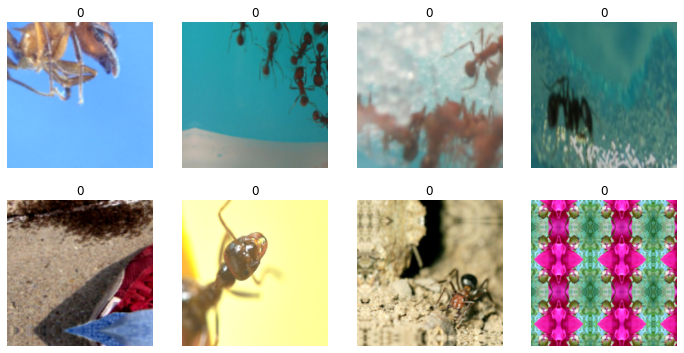

<IPython.core.display.Javascript object>

In [ ]:
transforms = aug_transforms(260, 224, mult=1.0)

mapper = ClassificationMapper(transforms)
dset = ClassificationDataset(mapper, parser)
dls = DataLoader(dset, batch_size=8, shuffle=False)

samples = next(iter(dls))
show_image_batch(samples)

> Note: You might want to add `RandomErasing` with these transformations. But random erasing must be applied after normalization of the batch so to apply random erasing we need to pass this transform directly into our mapper.

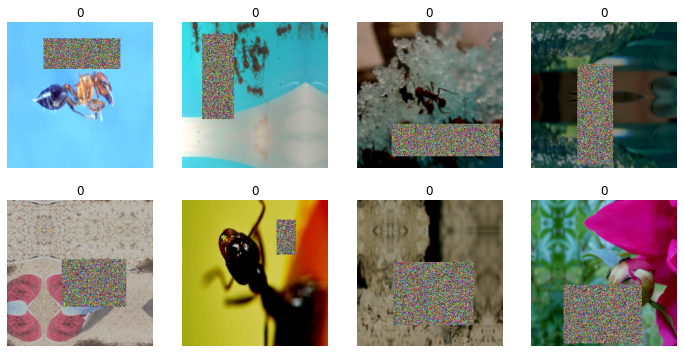

<IPython.core.display.Javascript object>

In [ ]:
from timm.data.random_erasing import RandomErasing

re = RandomErasing(1.0, mode="pixel", device="cpu")

# # or alternatively:
# from torchvision.transforms import RandomErasing
# re = RandomErasing(1.0)

transforms = aug_transforms(260, 224, mult=2.0)

mapper = ClassificationMapper(transforms, xtras=re)
dset = ClassificationDataset(mapper, parser)

dls = DataLoader(dset, batch_size=8, shuffle=False)

samples = next(iter(dls))
show_image_batch(samples)

## Export-

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()

Converted 00_core.utils.logger.ipynb.
Converted 00a_core.utils.visualize.ipynb.
Converted 00b_core.utils.structures.ipynb.
Converted 01_core.nn.utils.ipynb.
Converted 01a_core.nn.losses.ipynb.
Converted 02_core.nn.optim.optimizers.ipynb.
Converted 02a_core.nn.optim.lr_schedulers.ipynb.
Converted 03_core.classes.ipynb.
Converted 04_classification.modelling.backbones.ipynb.
Converted 04a_classification.modelling.heads.ipynb.
Converted 04b_classification.modelling.meta_arch.common.ipynb.
Converted 04b_classification.modelling.meta_arch.vit.ipynb.
Converted 05_classification.data.common.ipynb.
Converted 05a_classification.data.transforms.ipynb.
Converted 05b_classification.data.build.ipynb.
Converted 06_collections.pandas.ipynb.
Converted 06a_collections.callbacks.notebook.ipynb.
Converted 06b_collections.callbacks.ema.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>